# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch stuff
import torch
torch.manual_seed(0)
from torch import optim, nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models, datasets
from torch.utils.data import DataLoader, Dataset, random_split
#import torchvision.datasets as datasets

# Solo para Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd')

# GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Datasets and Dataloaders

In [4]:
DATA_PATH = 'Your database PATH'
TRAIN_SIZE = 50000
VAL_SIZE = 5000
TEST_SIZE = 5000
MINIBATCH_SIZE = 512

# Transformations for the TRAINING SET
transform_cifar10_train = T.Compose([
    T.RandomHorizontalFlip(p=0.3),
    T.ColorJitter(brightness=0.1, contrast=0.1, hue=0.05),
    T.RandomApply([T.RandomRotation(10), T.Resize(40), T.CenterCrop(32)], p=0.1),
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
])

In [5]:
# Transformations for the VALIDATION (VAL) and TEST (TEST) SET
transform_cifar10_test = T.Compose([
    T.ToTensor(),
    T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.262])
])

In [6]:
# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=transform_cifar10_train)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, shuffle=True)

# Dataset for validation and test
cifar10_val_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, transform=transform_cifar10_test)
val_dataset, test_dataset = random_split(cifar10_val_test, [VAL_SIZE, TEST_SIZE])

# Dataloader for validation and test
val_loader = DataLoader(val_dataset, batch_size=MINIBATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=MINIBATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\alvar\Documentos\Jupyter-Projects\Examples\Databases\cifar-10
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.3)
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=None, hue=(-0.05, 0.05))
               RandomApply(
               p=0.1
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=40, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(32, 32))
           )
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])
           )

In [8]:
val_loader.dataset

# Show data

In [9]:
def plot_figure(image):
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [10]:
cifar10_val_test

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:\Users\alvar\Documentos\Jupyter-Projects\Examples\Databases\cifar-10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])
           )

La imagen mostrada representa un: horse


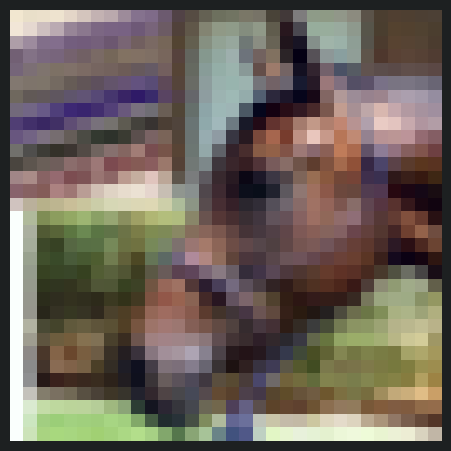

In [11]:
rnd_sample = np.random.randint(VAL_SIZE+TEST_SIZE)
# The validation and test dataset are loaded
classes = cifar10_val_test.classes
# Gets the correct label from the image
print(f'La imagen mostrada representa un: {classes[test_loader.dataset[rnd_sample][1]]}')
image = test_loader.dataset[rnd_sample][0]
image = (image - image.min()) / (image.max() - image.min())
plot_figure(image)

# Image Grid

In [12]:
def plot_cifar10_grid():
    classes = train_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15, 15))
    for idx_class, class_name in enumerate(classes):
        class_idxs = np.flatnonzero(idx_class == np.array(train_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace=False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i * len(classes) + idx_class + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(train_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(class_name)
    plt.show()

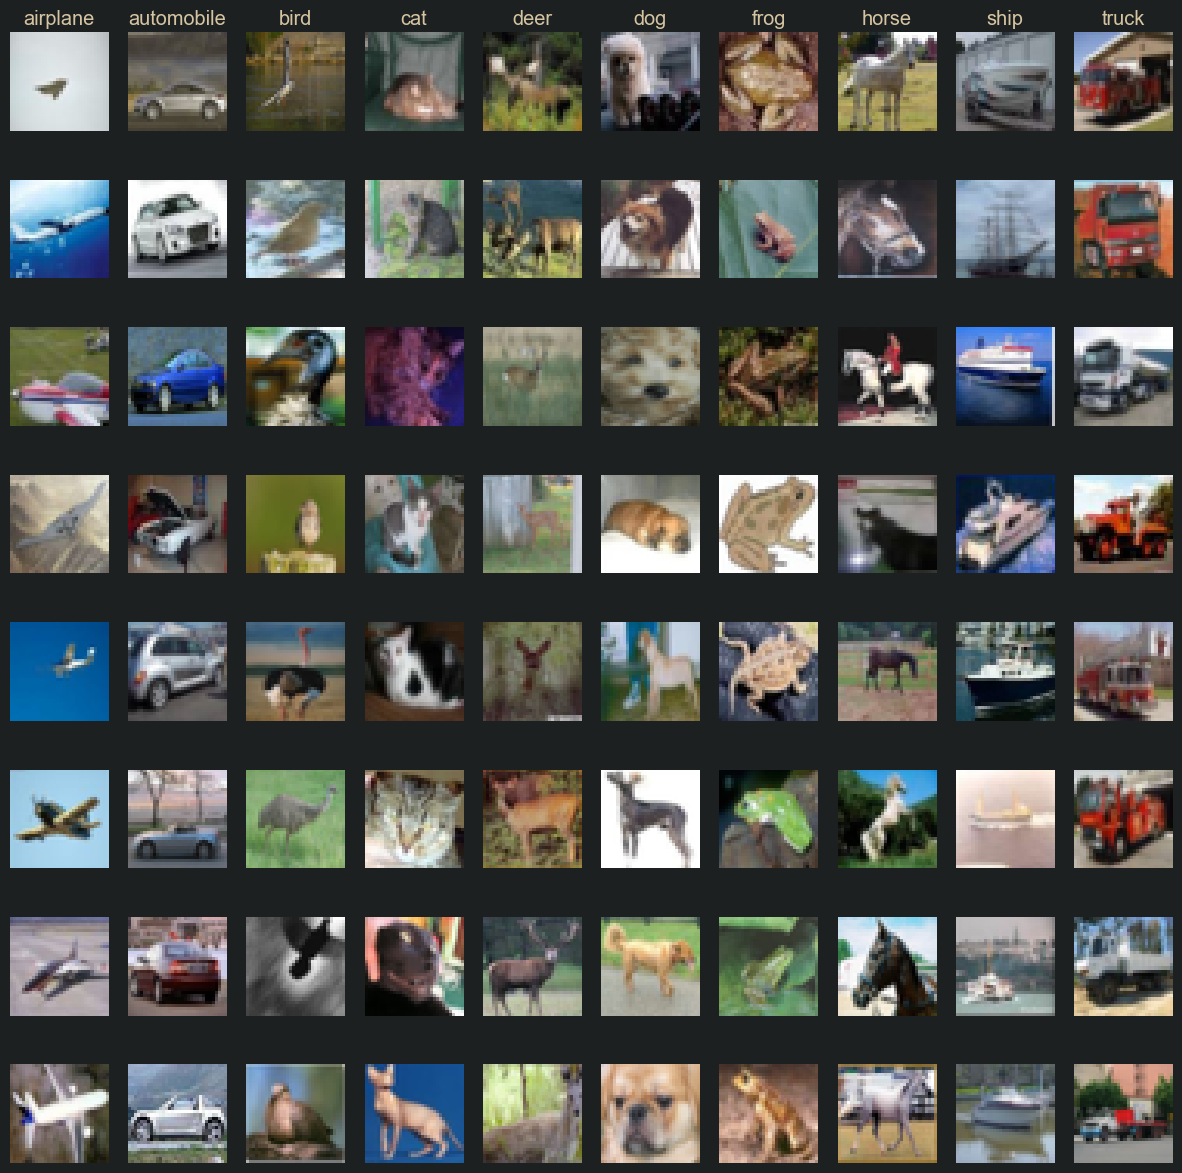

In [13]:
plot_cifar10_grid()

# Accuracy

In [14]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    cost = 0
    model.eval()
    # The model is loaded to the GPU
    model = model.to(device=device)
    # Training layers are turned off
    with torch.no_grad():
        # It iterates over the minibatches created by DataLoader
        for x, y in loader:
            # Images are uploaded to the GPU
            x = x.to(device=device, dtype=torch.float32)
            # Labels are uploaded to the GPU
            y = y.to(device=device, dtype=torch.long)
            # The predictions is obtained for the input data.
            scores = model(x)
            # The cost is calculated for each minibatch and is added in the following variable.
            cost += (F.cross_entropy(scores, y)).item()
            # The prediction index is saved.
            _, pred = scores.max(dim=1)
            # If the prediction matches the actual value, it is added.
            num_correct += (pred == y).sum()            
            num_total += pred.size(0)
        return cost/len(loader), float(num_correct) / num_total

# Search Learning Rate

The One Cycle is carried out, that is why the epochs are not used.

In [15]:
def find_lr(model, optimiser, start_val=1e-6, end_val=1, beta=0.99, loader=train_loader):
    # Number of mini batches in the DataLoader (minus 1 because the first one counts as 0)
    # This avoids division by zero.
    n = len(loader)-1
    
    # The factor is calculated which is calculated with the min and max value of the lr. 
    # The max value is divided by the min and the result is raised to 1/Total minibatches
    # It is the value that allows us to increase the lr
    factor = (end_val / start_val) ** (1/n)
    
    # The lr is initialized with the min value.
    lr = start_val    
    
    # The lr parameter of the optimizer is accessed and updated with the lr value
    optimiser.param_groups[0]['lr'] = lr
    
    # The values of average loss, loss and precision are initialized.
    avg_loss, loss, acc = 0., 0., 0.
    # The value of the lowest loss is initialized
    lowest_loss = 0.
    # The value of the current mini batch is initialized
    batch_num = 0
    
    # Lists are created to store the progress of 'loss', 'lr', 'precision' respectively
    losses = []
    log_lrs = []
    accuracies = []
    
    model = model.to(device=device)
    # To avoid division by zero, the index starts at 1
    for i, (x, y) in enumerate(loader, start=1):
    #for i, (x, y) in enumerate(loader):
        # Data is uploaded to the available device (GPU/CPU)
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)
        # Gradients are emptied so they do not accumulate
        optimiser.zero_grad()
        # Predictions are obtained for each minibatch
        scores = model(x)
        # The cost of the model is calculated
        cost = F.cross_entropy(input=scores, target=y)
                
        '''
        EWMA IMPLEMENTATION (Exponentially Weighted Moving Average)        
        Mathematically, it is written as: EWMA(t) = a * x(t) + (1-a) * EWMA(t-1)
        '''
        loss = beta * loss + (1-beta) * cost.item()
        
        # BIAS CORRECTION
        # NORMALIZATION OF LOSS
        avg_loss = loss/(1 - beta**i)
        
        # Accuaracy calculation
        acc_ = ((torch.argmax(scores, dim=1) == y).sum()/scores.size(0))        
        
        # If the loss is very large, there is no point in continuing.
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'From here {i, cost.item()}')
            return log_lrs, losses, accuracies
        # If the average loss is less than the lowest loss that has been had so far
        # then the lowest loss will be said average. If this is not the case, the calculation will continue.
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        # THE FOLLOWING VALUES ARE SAVED IN THEIR CORRESPONDING LISTS        
        accuracies.append(acc_.item())                
        losses.append(avg_loss)                
        log_lrs.append(lr)
        
        # STEP
        cost.backward()
        optimiser.step()
        
        # UPDATE LR
        print(f'Cost: {cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies

# Loop de entrenamiento

In [16]:
def train(model, optimiser, scheduler=None, epochs=100):
    model = model.to(device=device)
    # Lists to store validation and training loss values
    val_loss_history = []
    train_loss_history = []
    
    # Lists to store validation and training accuracy values
    val_acc_history = []
    train_acc_history = []
    
    # List to store the different lrs that are generated throughout the training
    lrs = []
    
    train_cost = 0.
    val_cost = 0.
    train_cost_num = 0.
    
    for epoch in range(epochs):  
        train_correct_num  = 0
        train_total = 0
        train_cost_acum = 0
        for i, (xi, yi) in enumerate(train_loader, start=1):
            # Training mode is activated. Activate all layers of the model.        
            model.train()
            
            # Data is uploaded to the GPU
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            
            # The prediction is made
            scores = model(xi)
            
            # Cost function is calculated
            cost = F.cross_entropy(input=scores, target=yi)
            
            # As multiple iterations are performed, the optimizer is reset 
            # (the gradients already calculated are deleted)
            optimiser.zero_grad()
            
            # Backward is performed
            cost.backward()
            
            # The parameters are updated
            optimiser.step()
            
            
            '''
            SCHEDULER.STEP()
            It allows us to make a step of our scheduler object that would update the lr according to the policy 
            that is being used (in this case One Cycle LR)
            '''
            if scheduler: scheduler.step()
            
            # COUNTERS THAT ACCUMULATE VALUES THAT WILL BE USED AT THE END OF EACH EPOCH
            train_correct_num += (torch.argmax(scores, dim=1) == yi ).sum()
            train_total +=  scores.size(0)
            train_cost_acum += cost.item()
            train_acc = float(train_correct_num) / train_total
            val_cost, val_acc = accuracy(model, val_loader)
            
            # THE DATA IS ADDED TO ITS CORRESPONDING LIST
            val_loss_history.append(val_cost)
            train_loss_history.append(cost.item())
            val_acc_history.append(val_acc)
            train_acc_history.append(train_acc)
            lrs.append(optimiser.param_groups[0]['lr'])
        
        # IT IS CALCULATED AFTER IT FINISHES GOING THROUGH ALL THE MINIBATCHES        
        train_acc = float(train_correct_num) / train_total
        train_cost = train_cost_acum / len(train_loader)
        print(f'Epoch: {epoch}, train_cost: {train_cost:.6f}, val_cost: {val_cost:.6f}'
              f'train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, total: {train_total}'
              f'lr: {optimiser.param_groups[0]["lr"]:.6f}')
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs        

# ResNet 56

In [17]:
# Function for a layer with a kernel of 3
# By having a kernel of 3 and padding of 1, the input dimension is maintained (only if stride=1).
def conv_k3(channel1, channel2, stride):
    return nn.Conv2d(channel1, channel2, stride=stride, kernel_size=3, padding=1)

# Creation of a residual block

Let's remember that in a residual block there is a layer jump, it is almost always one layer. The input of the first layer is added to the output of the second layer.

![Residual Block](https://miro.medium.com/v2/resize:fit:434/0*sGlmENAXIZhSqyFZ)

![Identity and Convolution](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Li2AMOhYtNHVEpizodC4sQ.png)

In [18]:
class residual_block(nn.Module):
    '''
    * in_channel: Image input volume. At first it depends on the type of image, if it is B&W it has a
     channel (1), if it is color it has three RGB colors (3). Then it will depend on the number of filters
     applied.
    * out_channel: Number of filters applied to this layer. This number determines the VOLUME of the 
    Feature MAP.
    * stride: Number of pixels for displacement (default=1).
    * change_size: Indicates if the dimension of this block will be modified (True, False)
    '''
    def __init__(self, in_channel, out_channel, stride=1, change_size=True):
        super().__init__()
        self.conv1 = conv_k3(in_channel, out_channel, stride)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = conv_k3(out_channel, out_channel, 1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.change_size = change_size
        
        # Reduction of output size
        if change_size:
            '''
            A layer is created with a 1x1 kernel, if the stride is greater than one the output dimension 
            will be reduced, but if the stride is 1 the dimension will be maintained and only an extra 
            Normalization would be applied.
            '''
            self.residual = nn.Sequential(nn.Conv2d(in_channel,
                                                   out_channel,
                                                   kernel_size=1,
                                                   stride=stride),
                                         nn.BatchNorm2d(out_channel))
    '''
    X: In this case it is no longer a tensioner. For the residual block, 'x' is the output of the previous
    layer and in the first layer the 'x' refers to the same input. This can be easily observed in the 
    forward of the ResNet56 class, where the variable 'y' is passed as a parameter, which refers to the 
    output of a previous layer.            
    '''
    def forward(self, x):
        # If there is no size change, no change is applied to the entry. Otherwise it is passed to the 
        # input through the residual layer to reduce its size.        
        identity = x if not self.change_size else self.residual(x)
        
        '''
        self.conv1(x): Apply the first convolution to the X tensor.
        self.bn1(): Apply a normalization to the output of the convolution.
        F.relu(): Apply the relu activation function to the output of the normalization.
        '''
        y = F.relu(self.bn1(self.conv1(x)))
        
        # The activation function is not applied because the initial input has not yet been added.
        y = self.bn2(self.conv2(y))
        
        # X is added to the output of the second convolution --> F(X) + X        
        y+= identity
        
        # The activation function is applied to the sum and returned.
        return F.relu(y)

Let's remember that CIFAR-10 is being used, which contains 50k training images and 10k for testing, with a total of 10 classes.  
In the paper Deep Residual Learning for Image Recognition (Kaiming He - Xiangyu Zhang - Shaoqing Ren - Jian Sun) it tells us that for the 20, 32, 44 and 56 layer architectures a value of n equal to 3, 5, 7 is used. and 9 respectively.  
In this case we are working with ResNet56 so we take n=9.

In [19]:
'''
Class for the creation of ResNet56, the architecture described in the paper on which we are working is 
implemented (Page 7).
Here it tells us that the first layer contains a 3x3 kernel (3x3 convolutions), it doesn't tell us anything 
else, we have to deduce the rest.
* in_channel: When working with color images, it is known that the input volume is 3 (RGB).
* out_channel: 
The same paper tells us that the filters that are used later are {16, 32, 64}, with this we can know that
in order to have the first amount of filters it is necessary to apply said amount to this layer, 
therefore 16 are used filters on this layer.
* Stride: A stride of 1 is used by default.
'''
class ResNet56(nn.Module):
    def __init__(self, n=9, num_classes=10):
        super().__init__()
        # First layer indicated on the paper. A normalization is also added to its output.
        self.conv1 = conv_k3(3, 16, 1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # CREATION OF THE BLOCKS
        
        # FIRST BLOCK: 
        self.block1 = self.create_block(n=9, in_channel=16,
                                       out_channel=16, stride=1,
                                       change_size=False)
        
        # SECOND BLOCK:        
        self.block2 = self.create_block(n=9, in_channel=16,
                                       out_channel=32, stride=2)
        
        # THIRD BLOCK        
        self.block3 = self.create_block(n=9, in_channel=32, 
                                        out_channel=64, stride=2)
        
        # FULLY CONNECTED LAYER
        # Receive a vector with 64 elements
        self.fc = nn.Linear(64, num_classes)
        
    '''
    FUNCTION FOR THE CREATION OF THE BLOCKS
    A list is created which will contain 'n' blocks. Each block has 2 convolutional layers.
    The first block will have a size change when necessary (only if change_size=True and stride is 
    greater than 1).
    The rest of the blocks will have an equal input and output and no size change will be applied.
    Finally, an nn.Sequential is returned with all the blocks (all the convolutional ones)
    '''
    def create_block(self, n, in_channel, out_channel, stride, change_size=True):
        block = [residual_block(in_channel, out_channel, stride, change_size=change_size)]
        for i in range(n-1):
            block.append(residual_block(out_channel, out_channel, stride=1, change_size=False))        
        return nn.Sequential(*block)
        
    '''    
    AVERAGE POOLING: It is usually applied to the output of the last convolutional layer 
    (instead of using a flattening layer, average pooling is used). In this way, a vector is obtained 
    whose size is equal to the volume of the input.        
    '''
    def forward(self, x):
        # FIRST CONVOLUTION        
        y = F.relu(self.bn1(self.conv1(x)))
        
        '''
        ALL BLOCKS
        It is a total of 3 blocks.
        Each block is an object of the residual_block class.
        Each object has a total of 2 convolutions and an extra convolution for dimension change 
        if required (change_size=True).         
        '''
        y = self.block3(self.block2(self.block1(y)))
        
        '''
        It receives the input 'y' and is indicated the size of the output '1' (1x1), 
        the output can also be indicated as a tuple (1x1).    
        '''
        y = F.adaptive_avg_pool2d(y, 1)
        
        '''
        The dimension of y is modified. With y.size(0) the size of the batch is obtained and with -1 it is
        indicated to take the resulting product of the other two dimensions.        
        '''
        return self.fc(y.view(y.size(0), -1))

# Creation of the model

In [20]:
model_resnet56 = ResNet56()

In [21]:
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                    lr=0.1, momentum=0.95,
                                    weight_decay=1e-4)

In [22]:
# Find the best learning rate
lg_lr, losses, accuracies = find_lr(model_resnet56, optimiser_resnet56, start_val=1e-6, end_val=10)

Cost: 2.5375, lr: 0.0000, acc: 0.1191
Cost: 2.5560, lr: 0.0000, acc: 0.0820
Cost: 2.4481, lr: 0.0000, acc: 0.1250
Cost: 2.4918, lr: 0.0000, acc: 0.1152
Cost: 2.4942, lr: 0.0000, acc: 0.1094
Cost: 2.5189, lr: 0.0000, acc: 0.1270
Cost: 2.4865, lr: 0.0000, acc: 0.1191
Cost: 2.5720, lr: 0.0000, acc: 0.0977
Cost: 2.5624, lr: 0.0000, acc: 0.0957
Cost: 2.4923, lr: 0.0000, acc: 0.1211
Cost: 2.4834, lr: 0.0000, acc: 0.1211
Cost: 2.6002, lr: 0.0000, acc: 0.0762
Cost: 2.5443, lr: 0.0000, acc: 0.1152
Cost: 2.5381, lr: 0.0000, acc: 0.0977
Cost: 2.5462, lr: 0.0000, acc: 0.1328
Cost: 2.4595, lr: 0.0000, acc: 0.1367
Cost: 2.4922, lr: 0.0000, acc: 0.1133
Cost: 2.4708, lr: 0.0000, acc: 0.1250
Cost: 2.5267, lr: 0.0000, acc: 0.0977
Cost: 2.5026, lr: 0.0000, acc: 0.1113
Cost: 2.4426, lr: 0.0000, acc: 0.1230
Cost: 2.4705, lr: 0.0000, acc: 0.1113
Cost: 2.4707, lr: 0.0000, acc: 0.1016
Cost: 2.4494, lr: 0.0000, acc: 0.1035
Cost: 2.4355, lr: 0.0001, acc: 0.1133
Cost: 2.4026, lr: 0.0001, acc: 0.1289
Cost: 2.4732

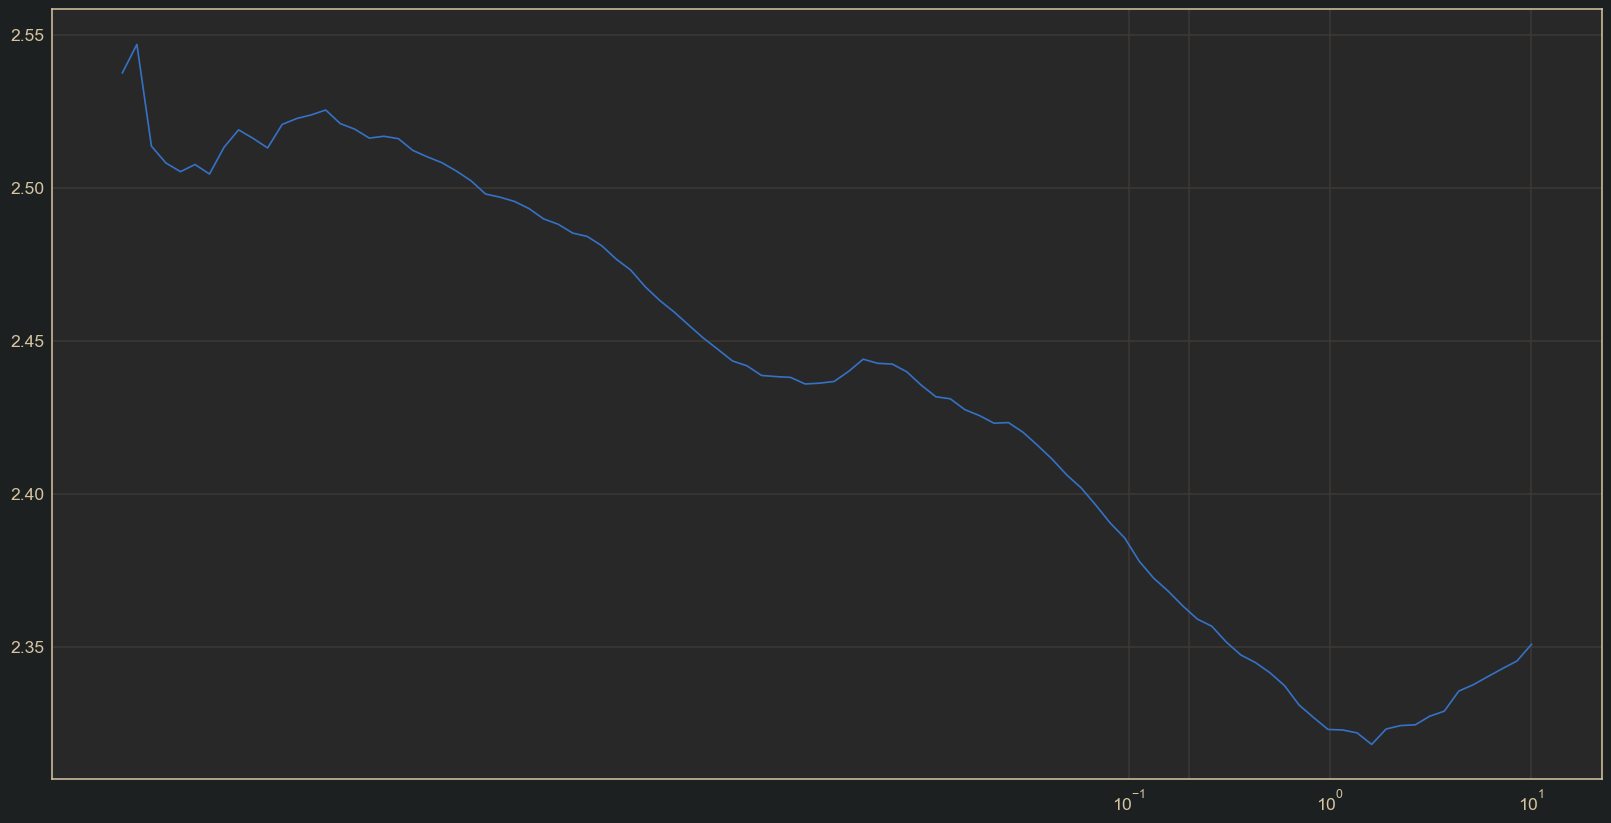

In [23]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
ax1.set_xticks([1e-1,2e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

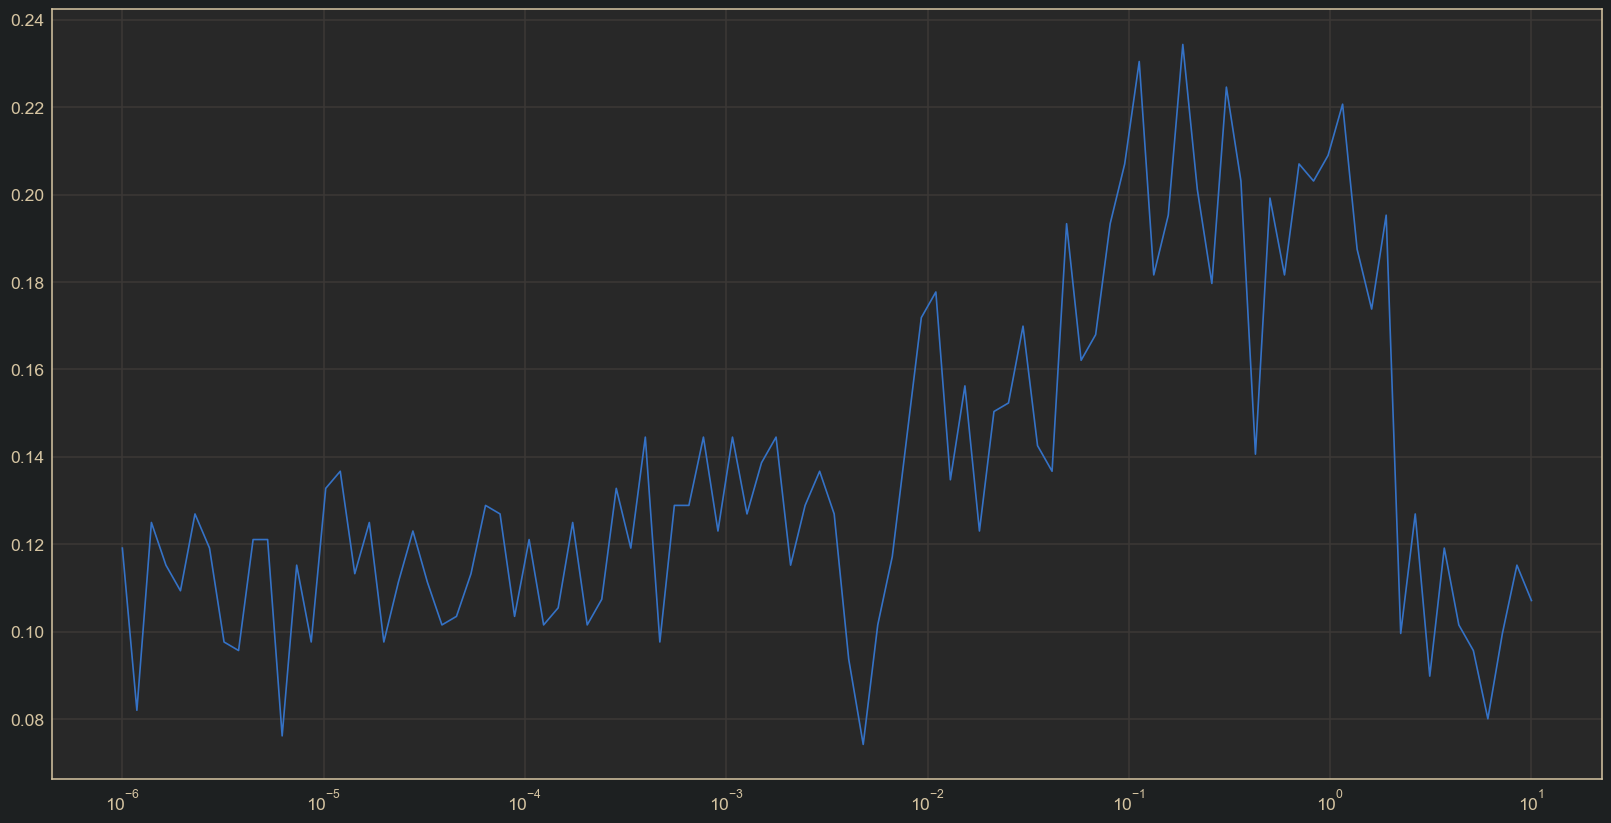

In [24]:
f1, ax1 = plt.subplots(figsize=(20,10))
# ax1.plot(lr[60:-2], losses[60:-2])
ax1.plot(lg_lr, accuracies)
ax1.set_xscale('log')
# ax1.set_xticks([1e-1, 2e-1,5e-1, 7e-1, 1, 10])
ax1.get_xaxis().get_major_formatter().labelOnlyBase = False
plt.show()

In [25]:
model_resnet56 = ResNet56()
optimiser_resnet56 = torch.optim.SGD(model_resnet56.parameters(),
                                     lr=0.1, momentum=0.95,
                                     weight_decay=1e-4)

In [26]:
epochs = 5
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_resnet56, 
                                                max_lr=2e-1, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs = epochs, pct_start=0.43, 
                                                div_factor=10,  
                                                final_div_factor=1000, 
                                                three_phase=True, verbose=False
                                            )

In [27]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history, lrs = train(
                                model_resnet56, 
                                optimiser=optimiser_resnet56,
                                scheduler=scheduler,
                                epochs = epochs
                                )

Epoch: 0, train_cost: 1.808842, val_cost: 2.133027train_acc: 0.3204, val_acc: 0.3172, total: 50000lr: 0.100780
Epoch: 1, train_cost: 1.359434, val_cost: 1.367250train_acc: 0.5022, val_acc: 0.5148, total: 50000lr: 0.198111
Epoch: 2, train_cost: 1.058960, val_cost: 0.960563train_acc: 0.6228, val_acc: 0.6846, total: 50000lr: 0.137272
Epoch: 3, train_cost: 0.816786, val_cost: 0.783043train_acc: 0.7122, val_acc: 0.7286, total: 50000lr: 0.027477
Epoch: 4, train_cost: 0.668984, val_cost: 0.643942train_acc: 0.7661, val_acc: 0.7704, total: 50000lr: 0.000030


In [29]:
print(f'Accuracy: {accuracy(model_resnet56, test_loader)}')

Accuracy: (0.637171596288681, 0.7786)


# Prediction with images

In [184]:
def plot_imgs(imgs, classes, preds):
    imgs_size = len(imgs)    
    fig, axes = plt.subplots(imgs_size, 3, figsize=(10, 30))
    for i in range(imgs_size):        
        
        # Normalize the image to show
        img = imgs[i, ...].permute(1, 2, 0).numpy()
        normalized_image = (img - img.min()) / (img.max() - img.min())
        
        # Display the image
        axes[i, 0].imshow(normalized_image)
        axes[i, 0].axis('off')
        
        # Display the first class
        axes[i, 1].text(0.5, 0.5, f'Real Class: {classes[i]}', ha='center', va='center', fontsize=12)
        axes[i, 1].axis('off')
        
        # Display the second class
        axes[i, 2].text(0.5, 0.5, f'Predict: {preds[i]}', ha='center', va='center', fontsize=12)
        axes[i, 2].axis('off')
        
    plt.tight_layout()
    plt.show()

In [185]:
# Images and it's class are obtained from the test loader.
imgs, classes = next(iter(test_loader))
# List with the name for each class
classes_name = train_loader.dataset.classes

In [186]:
# Get the first ten images and it's class
images_test = imgs[:10]
classes_test = classes[:10]

In [187]:
# Predictions are made with the trained model 
images_test_to = images_test.to(device, dtype=torch.float32)
model_resnet56 = model_resnet56.to(device)
with torch.no_grad():
    scores = model_resnet56(images_test_to)
    preds = torch.argmax(scores, dim=1).float()

In [188]:
# The numerical values (predictions or classes) are transformed to the corresponding name
real_name = [classes_name[i] for i in classes_test]
pred_name = [classes_name[int(i)] for i in preds]

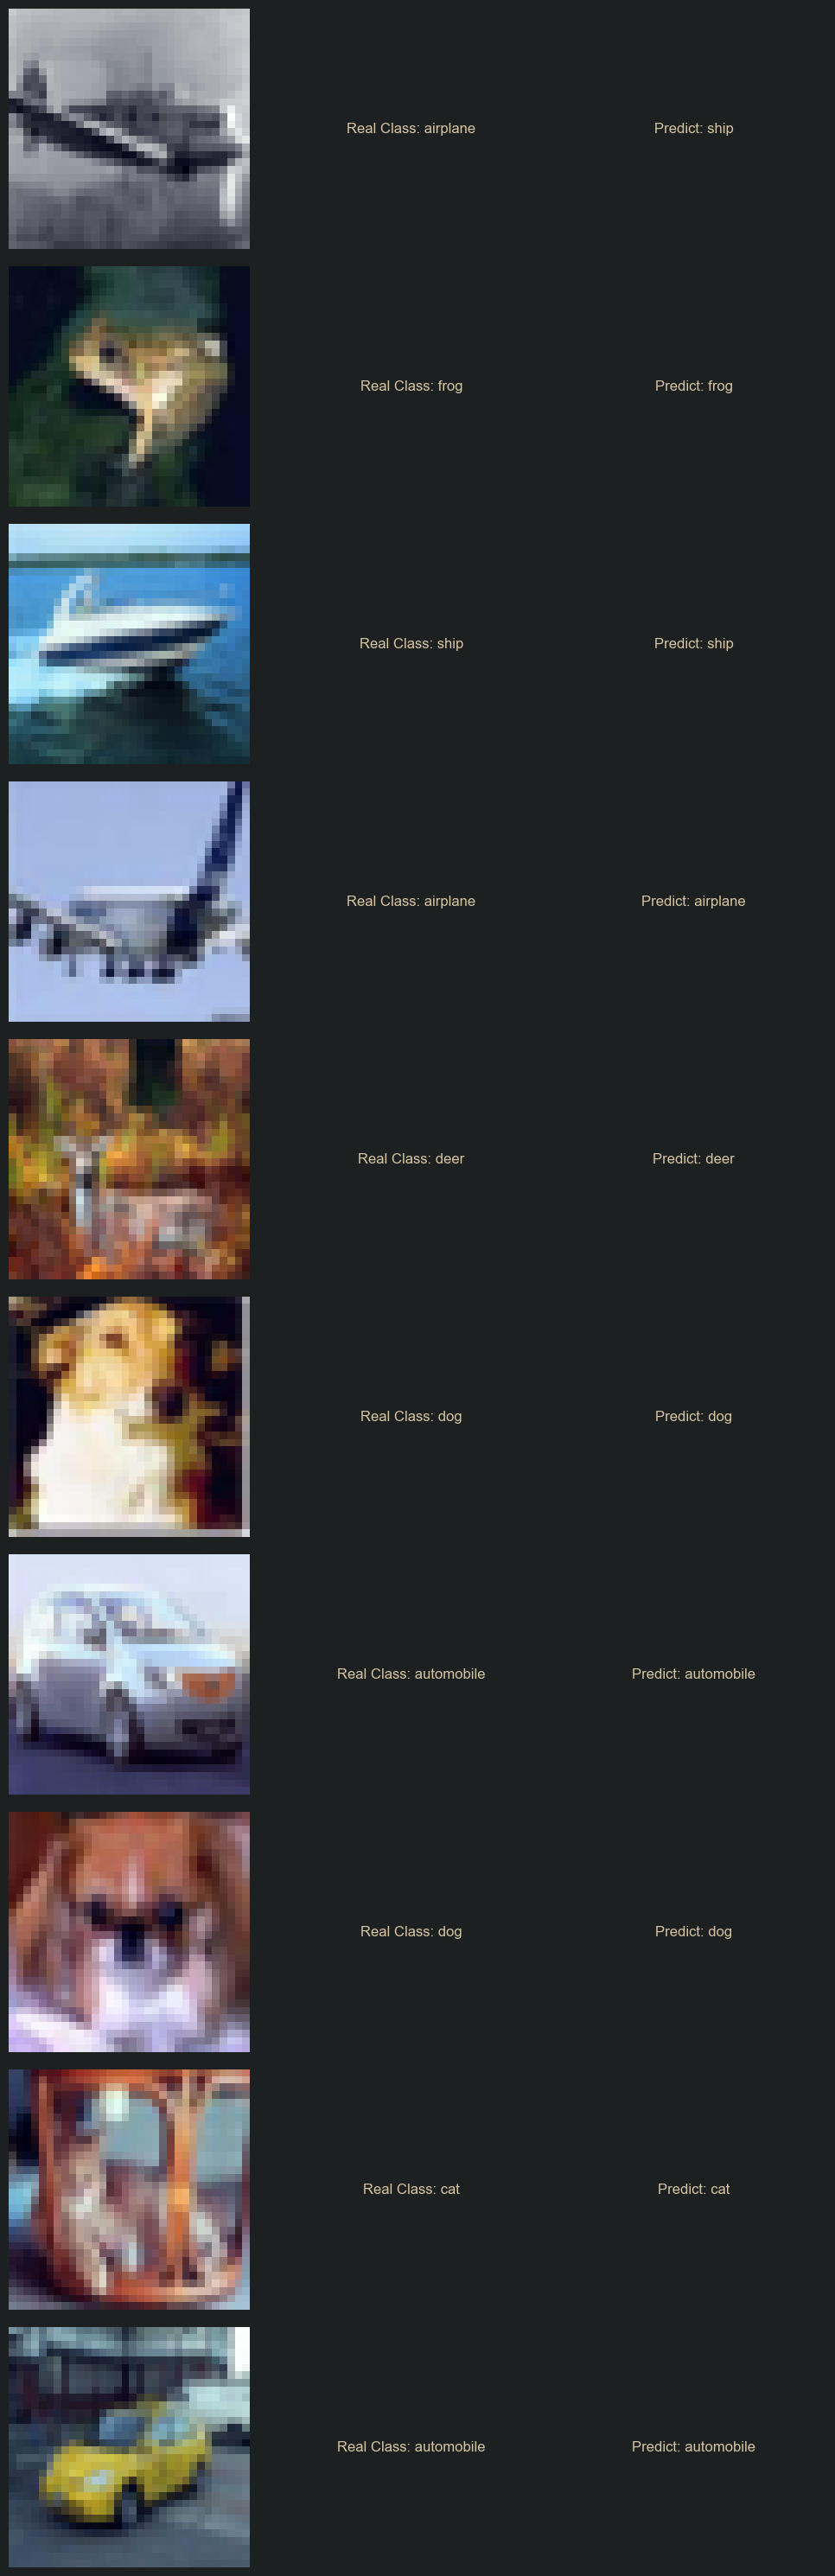

In [189]:
plot_imgs(images_test, real_name, pred_name)